The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.0


# Dog Breed Identification (ImageNet Dogs) on Kaggle

In this section, we will tackle the dog breed identification challenge in the Kaggle Competition. The competition's web address is

> https://www.kaggle.com/c/dog-breed-identification

In this competition, we attempt to identify 120 different breeds of dogs. The dataset used in this competition is actually a subset of the famous ImageNet dataset. Different from the images in the CIFAR-10 dataset used in the previous section, the images in the ImageNet dataset are higher and wider and their dimensions are inconsistent.

:numref:`fig_kaggle_dog` shows the information on the competition's webpage. In order to submit the results, please register an account on the Kaggle website first.

![Dog breed identification competition website. The dataset for the competition can be accessed by clicking the "Data" tab.](../img/kaggle-dog.jpg)
:width:`400px`
:label:`fig_kaggle_dog`

First, import the packages or modules required for the competition.


In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, npx
from mxnet.gluon import nn
import os

npx.set_np()

## Obtaining and Organizing the Dataset

The competition data is divided into a training set and testing set. The training set contains $10,222$ images and the testing set contains $10,357$ images. The images in both sets are in JPEG format. These images contain three RGB channels (color) and they have different heights and widths. There are 120 breeds of dogs in the training set, including Labradors, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers.

### Downloading the Dataset

After logging in to Kaggle, we can click on the "Data" tab on the dog breed identification competition webpage shown in :numref:`fig_kaggle_dog` and download the dataset by clicking the "Download All" button. After unzipping the downloaded file in `../data`, you will find the entire dataset in the following paths:

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../data/dog-breed-identification/train
* ../data/dog-breed-identification/test

You may have noticed that the above structure is quite similar to that of the CIFAR-10 competition in :numref:`sec_kaggle_cifar10`, where folders `train/` and `test/` contain training and testing dog images respectively, and `labels.csv` has the labels for the training images.

Similarly, to make it easier to get started, we provide a small-scale sample of the dataset mentioned above, "train_valid_test_tiny.zip". If you are going to use the full dataset for the Kaggle competition, you will also need to change the `demo` variable below to `False`.


In [2]:
#@save 
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### Organizing the Dataset

We can organize the dataset similarly to what we did in :numref:`sec_kaggle_cifar10`, namely separating a validation set from the training set, and moving images into subfolders grouped by labels.

The `reorg_dog_data` function below is used to read the training data labels, segment the validation set, and organize the training set.


In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

    
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## Image Augmentation

The size of the images in this section are larger than the images in the previous section. Here are some more image augmentation operations that might be useful.


In [4]:
transform_train = gluon.data.vision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height to width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new image with a height and width of 224
    # pixels each
    gluon.data.vision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                                   ratio=(3.0/4.0, 4.0/3.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    # Randomly change the brightness, contrast, and saturation
    gluon.data.vision.transforms.RandomColorJitter(brightness=0.4,
                                                   contrast=0.4,
                                                   saturation=0.4),
    # Add random noise
    gluon.data.vision.transforms.RandomLighting(0.1),
    gluon.data.vision.transforms.ToTensor(),
    # Standardize each channel of the image
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

During testing, we only use definite image preprocessing operations.


In [5]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    # Crop a square of 224 by 224 from the center of the image
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

## Reading the Dataset

As in the previous section, we can create an `ImageFolderDataset` instance to read the dataset containing the original image files.


In [6]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ('train', 'valid', 'train_valid', 'test')]

Here, we create `DataLoader` instances, just like in :numref:`sec_kaggle_cifar10`.


In [7]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True, 
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False, 
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False, 
    last_batch='keep')

## Defining the Model

The dataset for this competition is a subset of the ImageNet data
set. Therefore, we can use the approach discussed in
:numref:`sec_fine_tuning`
to select a model pre-trained on the
entire ImageNet dataset and use it to extract image features to be input in the
custom small-scale output network. Gluon provides a wide range of pre-trained
models. Here, we will use the pre-trained ResNet-34 model. Because the
competition dataset is a subset of the pre-training dataset, we simply reuse
the input of the pre-trained model's output layer, i.e., the extracted
features. Then, we can replace the original output layer with a small custom
output network that can be trained, such as two fully connected layers in a
series. Different from the experiment in
:numref:`sec_fine_tuning`, here, we do not retrain the pre-trained model used for feature
extraction. This reduces the training time and the memory required to store
model parameter gradients.

You must note that, during image augmentation, we use the mean values and standard deviations of the three RGB channels for the entire ImageNet dataset for normalization. This is consistent with the normalization of the pre-trained model.


In [8]:
def get_net(devices):
    finetune_net = gluon.model_zoo.vision.resnet34_v2(pretrained=True)
    # Define a new output network
    finetune_net.output_new = nn.HybridSequential(prefix='')
    finetune_net.output_new.add(nn.Dense(256, activation='relu'))
    # There are 120 output categories
    finetune_net.output_new.add(nn.Dense(120))
    # Initialize the output network
    finetune_net.output_new.initialize(init.Xavier(), ctx=devices)
    # Distribute the model parameters to the CPUs or GPUs used for computation
    finetune_net.collect_params().reset_ctx(devices)
    return finetune_net

When calculating the loss, we first use the member variable `features` to obtain the input of the pre-trained model's output layer, i.e., the extracted feature. Then, we use this feature as the input for our small custom output network and compute the output.


In [9]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        X_shards, y_shards = d2l.split_batch(features, labels, devices)
        output_features = [net.features(X_shard) for X_shard in X_shards]
        outputs = [net.output_new(feature) for feature in output_features]
        ls = [loss(output, y_shard).sum() for output, y_shard
              in zip(outputs, y_shards)]
        l_sum += sum([float(l.sum()) for l in ls])
        n += labels.size
    return l_sum / n

## Defining the Training Functions

We will select the model and tune hyperparameters according to the model's performance on the validation set. The model training function `train` only trains the small custom output network.


In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    trainer = gluon.Trainer(net.output_new.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            X_shards, y_shards = d2l.split_batch(features, labels, devices)
            output_features = [net.features(X_shard) for X_shard in X_shards]
            with autograd.record():
                outputs = [net.output_new(feature)
                           for feature in output_features]
                ls = [loss(output, y_shard).sum() for output, y_shard
                      in zip(outputs, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            metric.add(sum([float(l.sum()) for l in ls]), labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## Training and Validating the Model

Now, we can train and validate the model. The following hyperparameters can be tuned. For example, we can increase the number of epochs. Because `lr_period` and `lr_decay` are set to 10 and 0.1 respectively, the learning rate of the optimization algorithm will be multiplied by 0.1 after every 10 epochs.


train loss 2.050, valid loss 1.988
228.5 examples/sec on [gpu(0), gpu(1)]


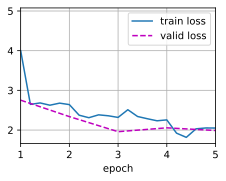

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.01, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## Classifying the Testing Set and Submitting Results on Kaggle

After obtaining a satisfactory model design and hyperparameters, we use all training datasets (including validation sets) to retrain the model and then classify the testing set. Note that predictions are made by the output network we just trained.


train loss 2.501
231.9 examples/sec on [gpu(0), gpu(1)]


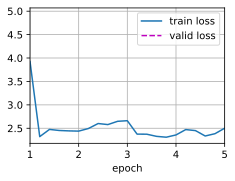

In [12]:
net = get_net(devices)
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output_features = net.features(data.as_in_ctx(devices[0]))
    output = npx.softmax(net.output_new(output_features))
    preds.extend(output.asnumpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.synsets) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

After executing the above code, we will generate a "submission.csv" file. The
format of this file is consistent with the Kaggle competition requirements. The
method for submitting results is similar to method in
:numref:`sec_kaggle_house`.


## Summary

* We can use a model pre-trained on the ImageNet dataset to extract features and only train a small custom output network. This will allow us to classify a subset of the ImageNet dataset with lower computing and storage overhead.


## Exercises

1. When using the entire Kaggle dataset, what kind of results do you get when you increase the `batch_size` (batch size) and `num_epochs` (number of epochs)?
1. Do you get better results if you use a deeper pre-trained model?
1. Scan the QR code to access the relevant discussions and exchange ideas about the methods used and the results obtained with the community. Can you come up with any better techniques?


[Discussions](https://discuss.d2l.ai/t/380)
